In [3]:
%matplotlib inline
from collections import defaultdict
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
#this mapping between states and abbreviations will come in handy later
states_abbrev = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [5]:
#adapted from  https://github.com/dataiap/dataiap/blob/master/resources/util/map_util.py

#load in state geometry
state2poly = defaultdict(list)

data = json.load(file("data/us-states.json"))
for f in data['features']:
    state = states_abbrev[f['id']]
    geo = f['geometry']
    if geo['type'] == 'Polygon':
        for coords in geo['coordinates']:
            state2poly[state].append(coords)
    elif geo['type'] == 'MultiPolygon':
        for polygon in geo['coordinates']:
            state2poly[state].extend(polygon)

            
def draw_state(plot, stateid, **kwargs):
    """
    draw_state(plot, stateid, color=..., **kwargs)
    
    Automatically draws a filled shape representing the state in
    subplot.
    The color keyword argument specifies the fill color.  It accepts keyword
    arguments that plot() accepts
    """
    for polygon in state2poly[stateid]:
        xs, ys = zip(*polygon)
        plot.fill(xs, ys, **kwargs)

        
def make_map(states, label):
    """
    Draw a cloropleth map, that maps data onto the United States
    
    Inputs
    -------
    states : Column of a DataFrame
        The value for each state, to display on a map
    label : str
        Label of the color bar

    Returns
    --------
    The map
    """
    fig = plt.figure(figsize=(12, 9))
    ax = plt.gca()

    if states.max() < 2: # colormap for election probabilities 
        cmap = cm.RdBu
        vmin, vmax = 0, 1
    else:  # colormap for electoral votes
        cmap = cm.binary
        vmin, vmax = 0, states.max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    skip = set(['National', 'District of Columbia', 'Guam', 'Puerto Rico',
                'Virgin Islands', 'American Samoa', 'Northern Mariana Islands'])
    for state in states_abbrev.values():
        if state in skip:
            continue
        color = cmap(norm(states.ix[state]))
        draw_state(ax, state, color = color, ec='k')

    #add an inset colorbar
    ax1 = fig.add_axes([0.45, 0.70, 0.4, 0.02])    
    cb1=mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                  norm=norm,
                                  orientation='horizontal')
    ax1.set_title(label)
    remove_border(ax, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-180, -60)
    ax.set_ylim(15, 75)
    return ax

In [6]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

In [7]:
electoral_votes = pd.read_csv("data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


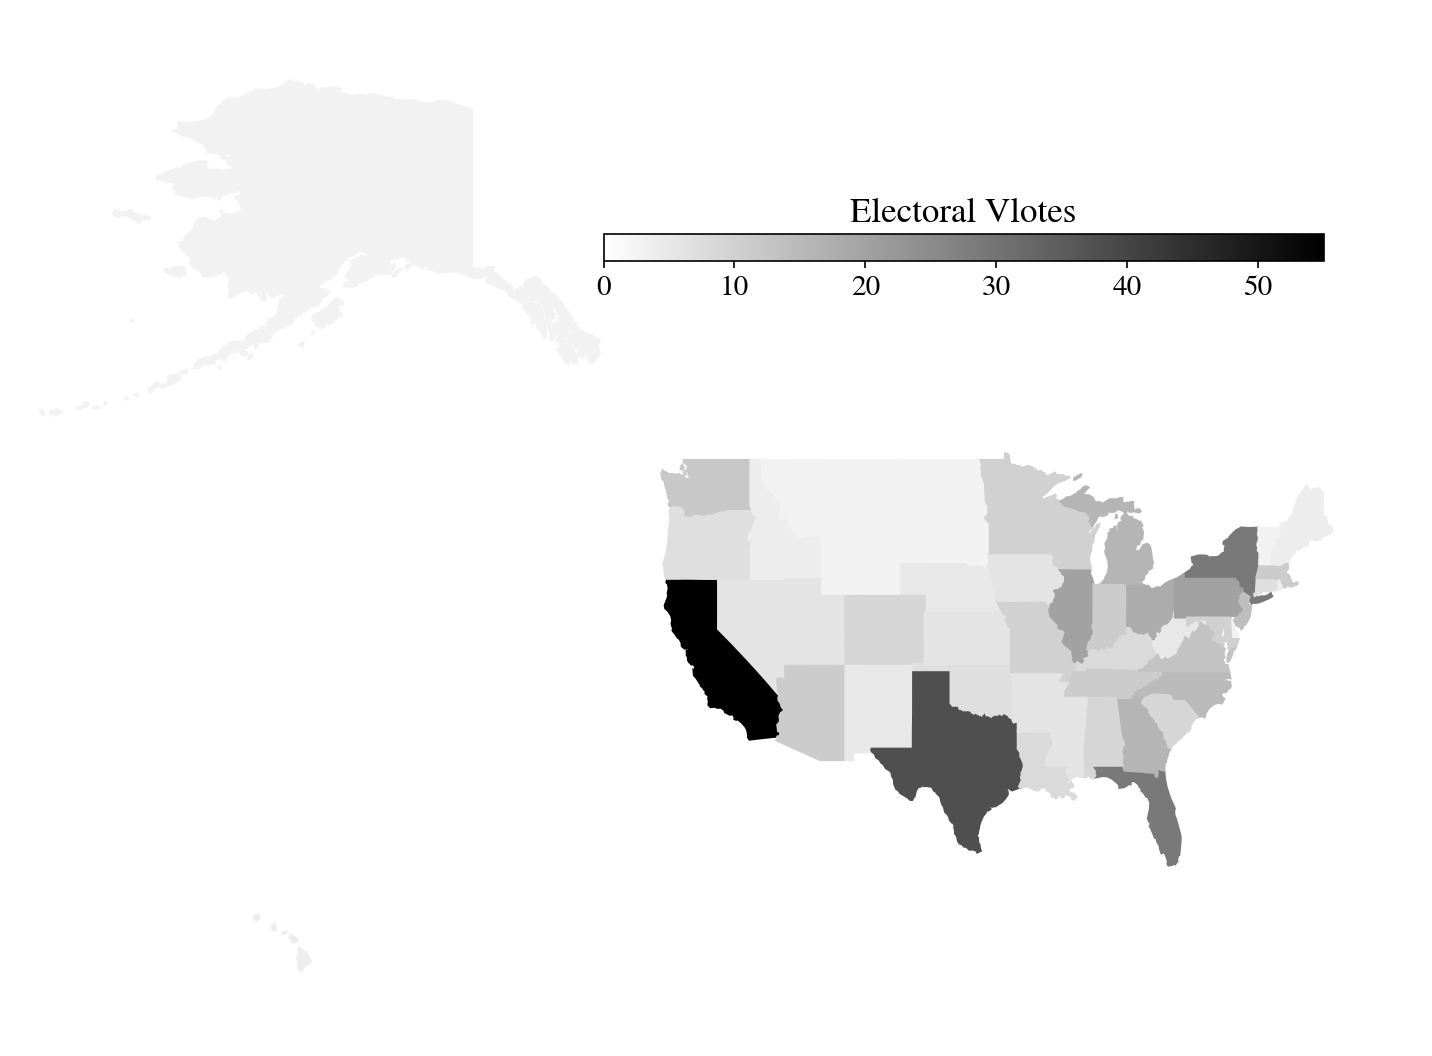

In [8]:
make_map(electoral_votes.Votes, "Electoral Vlotes")

In [9]:
predictwise = pd.read_csv('data/predictwise.csv').set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


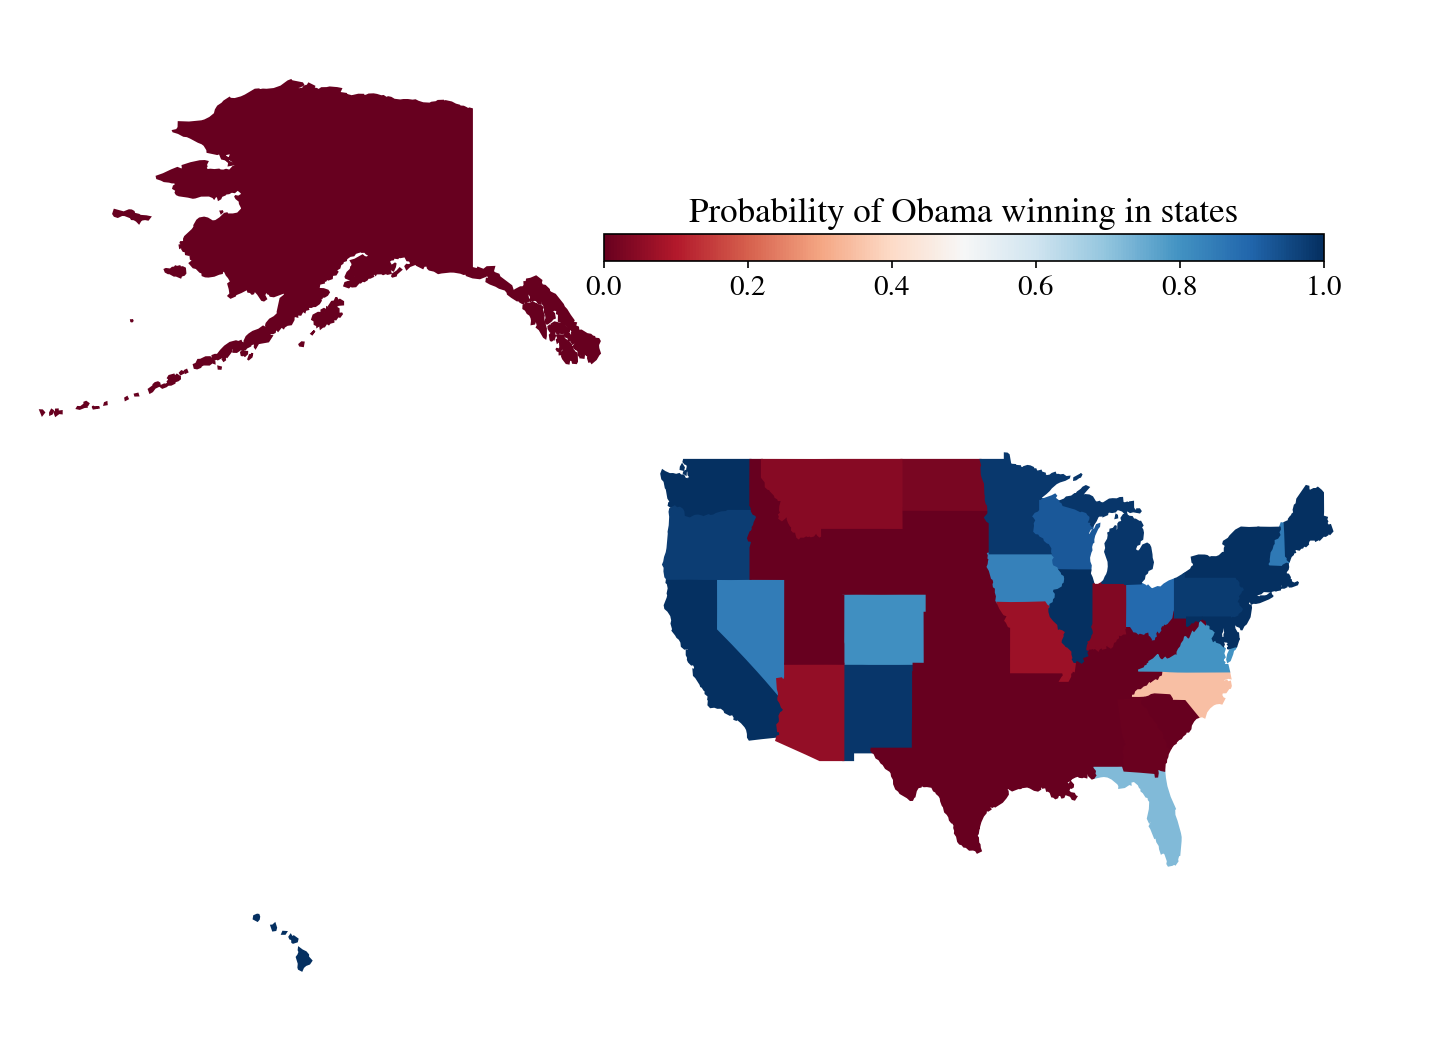

In [10]:
make_map(predictwise.Obama, "Probability of Obama winning in states")

Simulating the elections, given the probability of obama winning in the states.

In [11]:
from scipy.stats.distributions import bernoulli

def simulate_election(predictwise, n_sim):
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < predictwise.Obama.values.reshape(-1, 1)) * predictwise.Votes.values.reshape(-1, 1)
    #summing over rows gives the total electoral votes for each simulation
    return obama_votes.sum(axis=0)

results = simulate_election(predictwise, 1000)

Probability of obama winning the election given the above simulation:

In [12]:
def probToWin(results):
    totalVotes = 0

    for result in results:
        if result >= 269:
            totalVotes = totalVotes + result
        else:
            continue

    probabilityToWin = 1.0 * totalVotes / results.sum() * 100
    
    return probabilityToWin

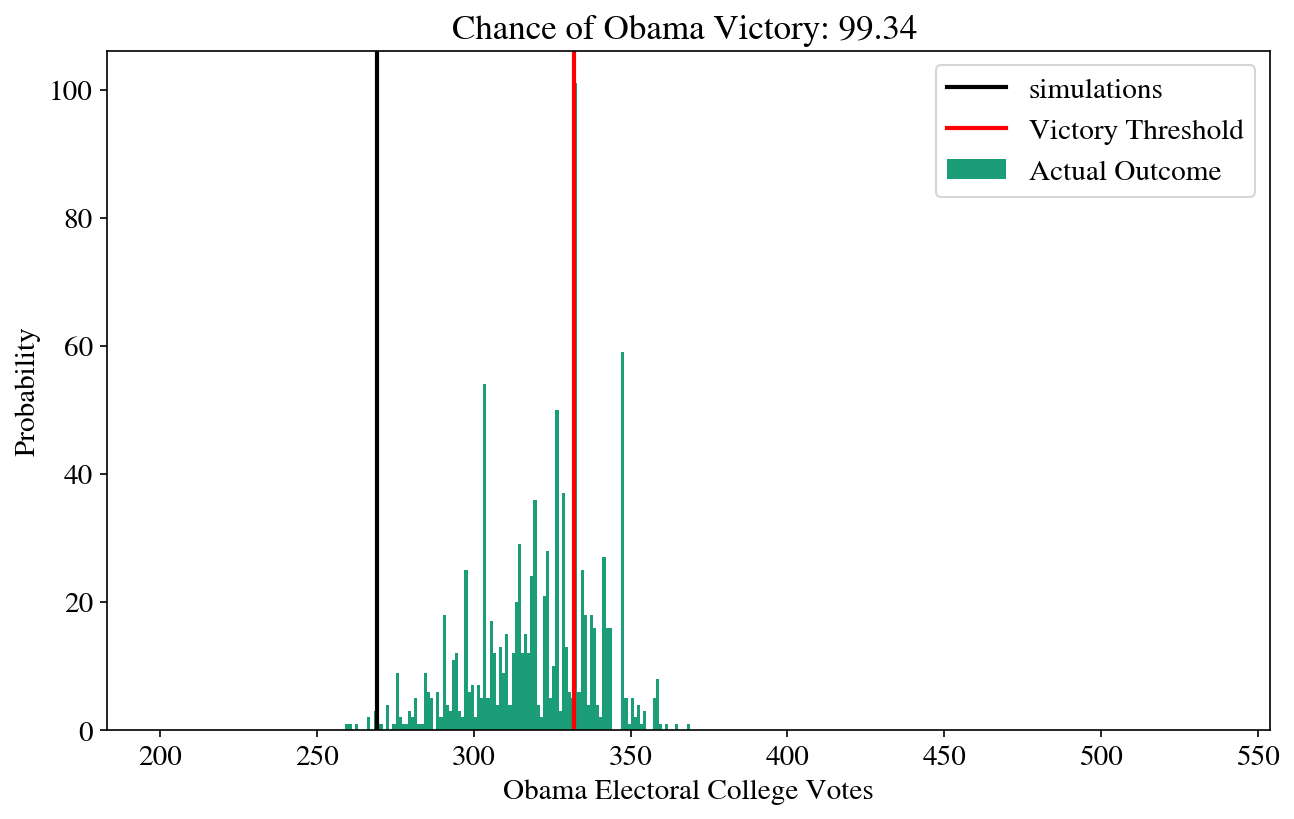

In [13]:
def plot_simulation(results):
    plt.hist(results, bins = np.arange(200, 538, 1))
    plt.axvline(x = 269, color = 'k')
    plt.axvline(x = 332, color = 'r')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    plt.legend(['simulations', 'Victory Threshold', 'Actual Outcome'])
    plt.title("Chance of Obama Victory: %0.2f "%(probToWin(results)))
    
plot_simulation(results)

Now, lets try to estimate our own winning probabilities for each state, given the political inclination of people of the given state.

In [14]:
gallupData = pd.read_csv('data/g12.csv', index_col = 'State')
gallupData["Unknown"] = 100 - gallupData.Democrat - gallupData.Republican
gallupData.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


Lets define a function to generate a model to generate probabilities for each state.

In [15]:
def simple_gallup_model(gallupData):
    gallupData['Obama'] = np.nan
    for i in range(len(gallupData)):
        if gallupData.Dem_Adv.iloc[i] > 0:
            gallupData.Obama.iloc[i] = 1
        else:
            gallupData.Obama.iloc[i] = 0
    return gallupData

s = simple_gallup_model(gallupData)
s.head()

C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Democrat,Republican,Dem_Adv,N,Unknown,Obama
State,,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4,0.0
Alaska,35.9,44.3,-8.4,402,19.8,0.0
Arizona,39.8,47.3,-7.5,4325,12.9,0.0
Arkansas,41.5,40.8,0.7,2071,17.7,1.0
California,48.3,34.6,13.7,16197,17.1,1.0


Running the simulation with this model and plotting it:

[334 334 334 ..., 334 334 334]


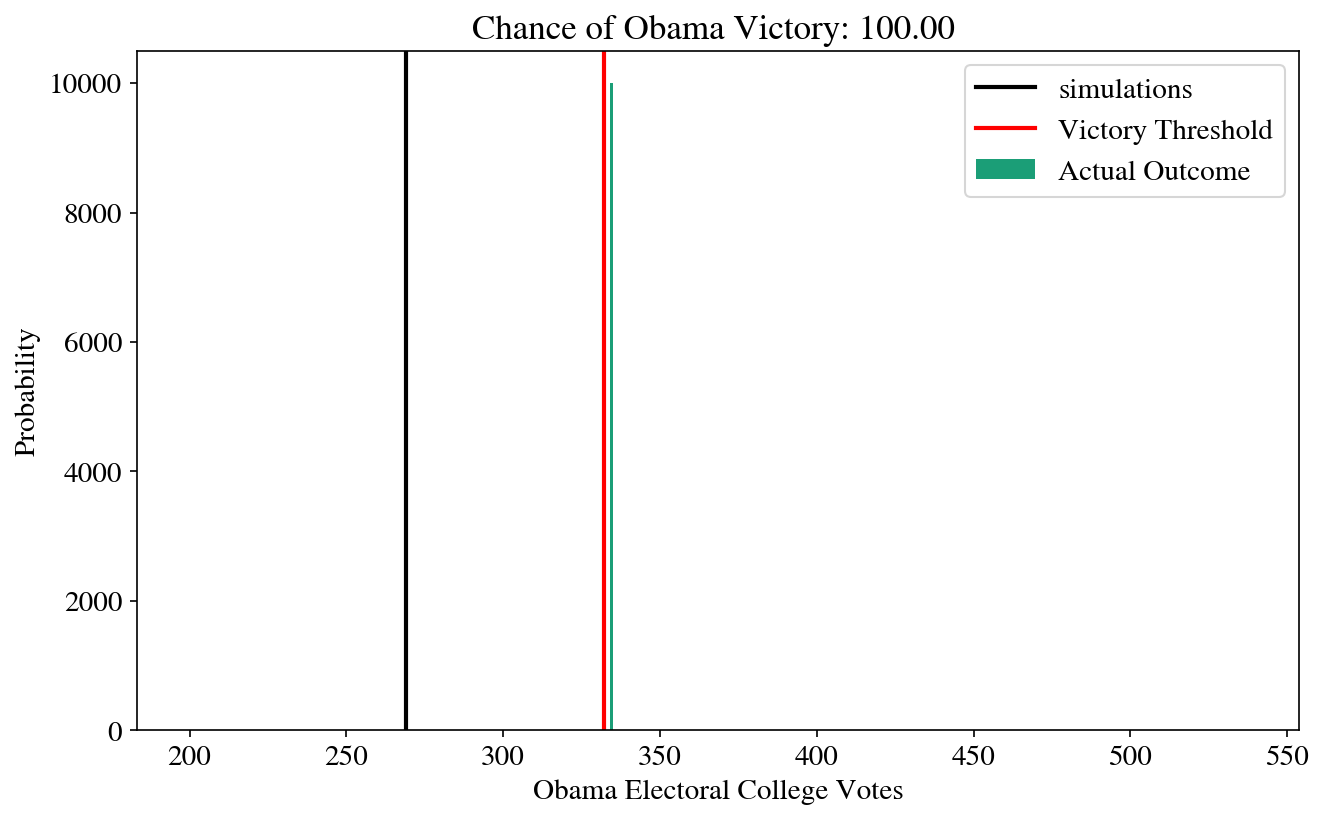

C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


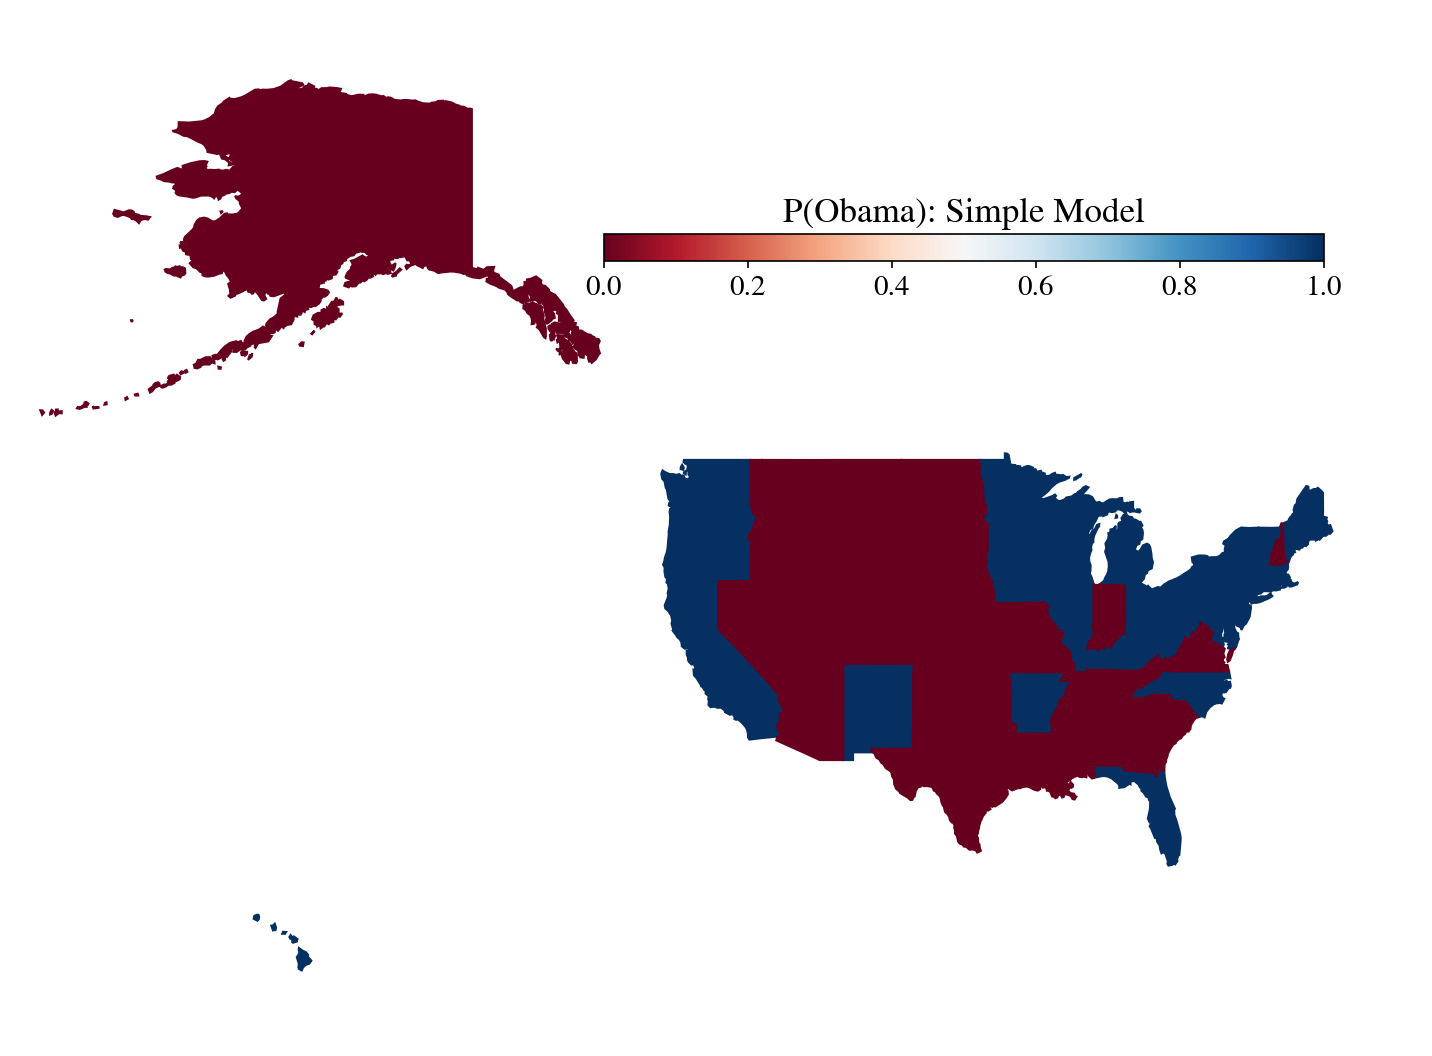

In [16]:
model = simple_gallup_model(gallupData)
model = model.join(electoral_votes)
prediction = simulate_election(model, 10000)
print prediction

plot_simulation(prediction)
plt.hist(prediction)
plt.show()
make_map(model.Obama, "P(Obama): Simple Model")

Accounting for the uncertainity in the model, lets make another model which considers 3% of sampling errors for each state

In [17]:
from scipy.special import erf
def uncertain_gallup_model(gallup):
    sigma = 3
    cdf =  0.5 * (1 + erf(gallup['Dem_Adv'] / np.sqrt(2 * sigma**2)))
    return pd.DataFrame(dict(Obama = cdf), index=gallup.index)

In [18]:
model = uncertain_gallup_model(gallupData)
model = model.join(electoral_votes)
model.head()

,Obama,Votes
State,,
Alabama,0.000003,9
Alaska,0.002555,3
Arizona,0.006210,11
Arkansas,0.592249,6
California,0.999998,55


C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


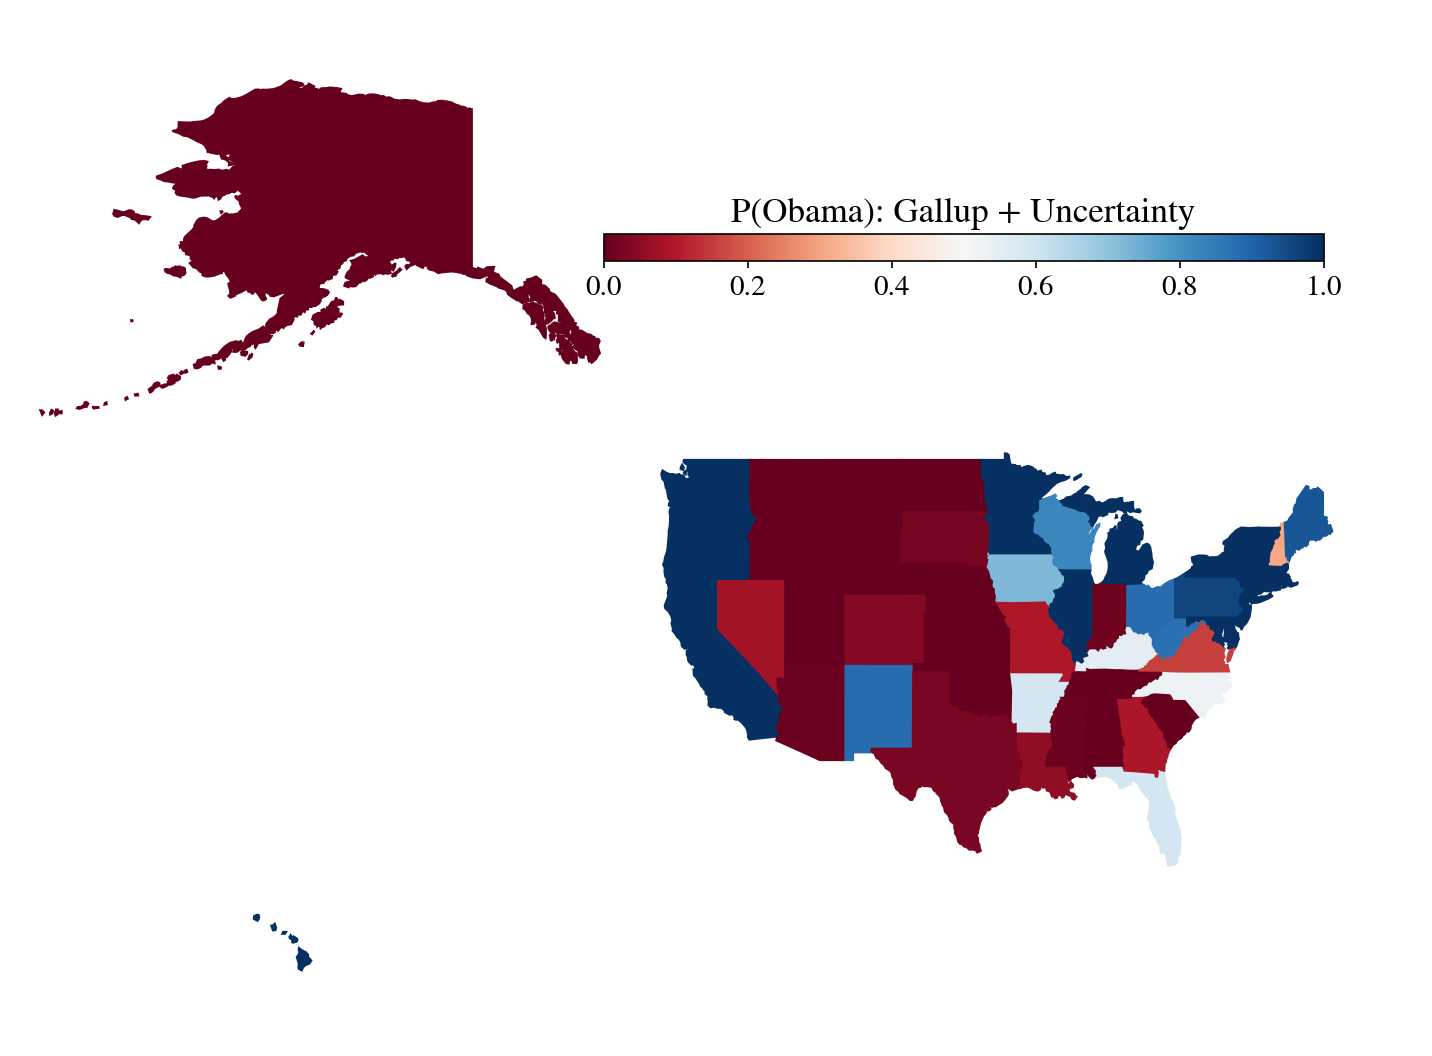

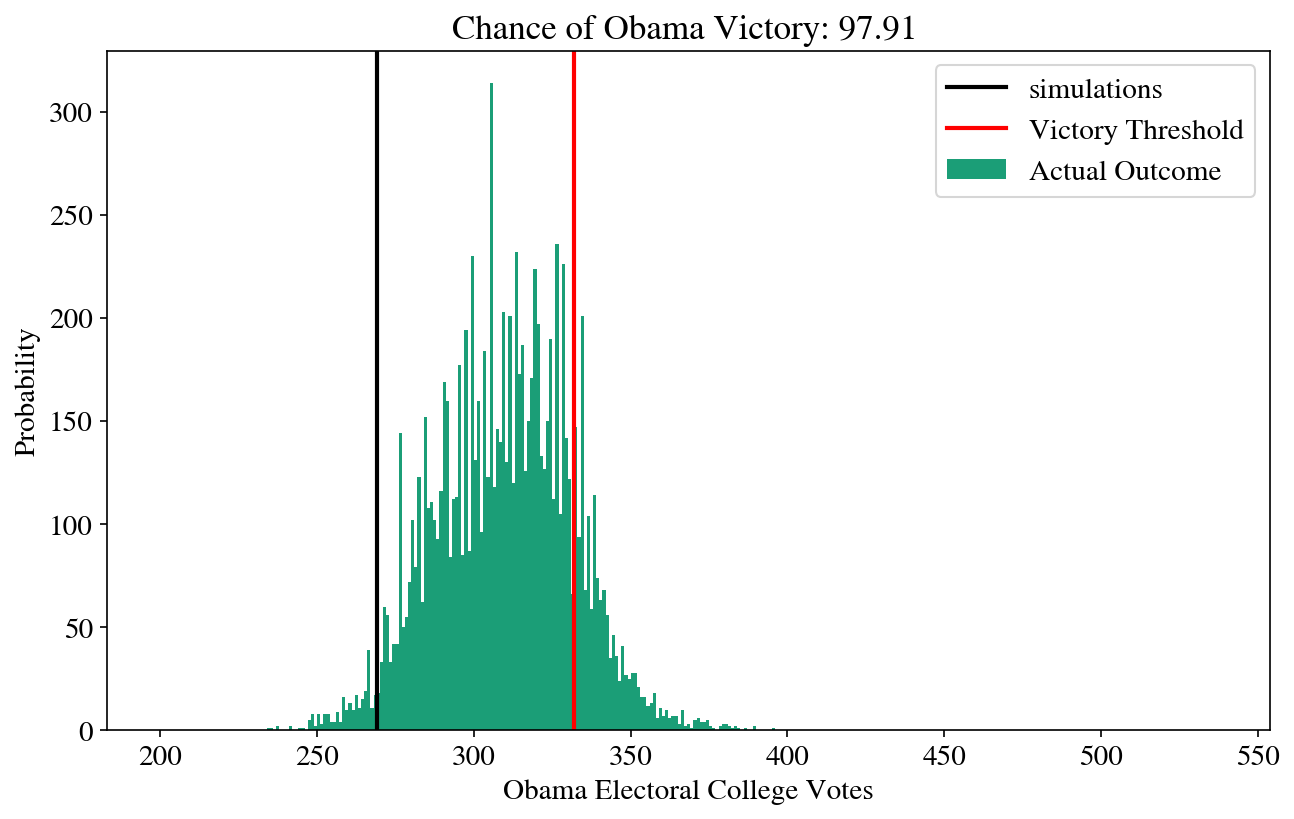

In [19]:
make_map(model.Obama, "P(Obama): Gallup + Uncertainty")
plt.show()
prediction = simulate_election(model, 10000)
plot_simulation(prediction)

Introducing bias to the given data:

In [20]:
def biased_gallup_poll(gallupData, bias):
    temp = gallupData.copy()
    temp['Dem_Adv'] = temp['Dem_Adv'] - bias
    
    return uncertain_gallup_model(temp)

model = biased_gallup_poll(gallupData, 1.0)
model.head()

,Obama
State,
Alabama,5.674811e-07
Alaska,8.641652e-04
Arizona,2.303266e-03
Arkansas,4.601722e-01
California,9.999885e-01


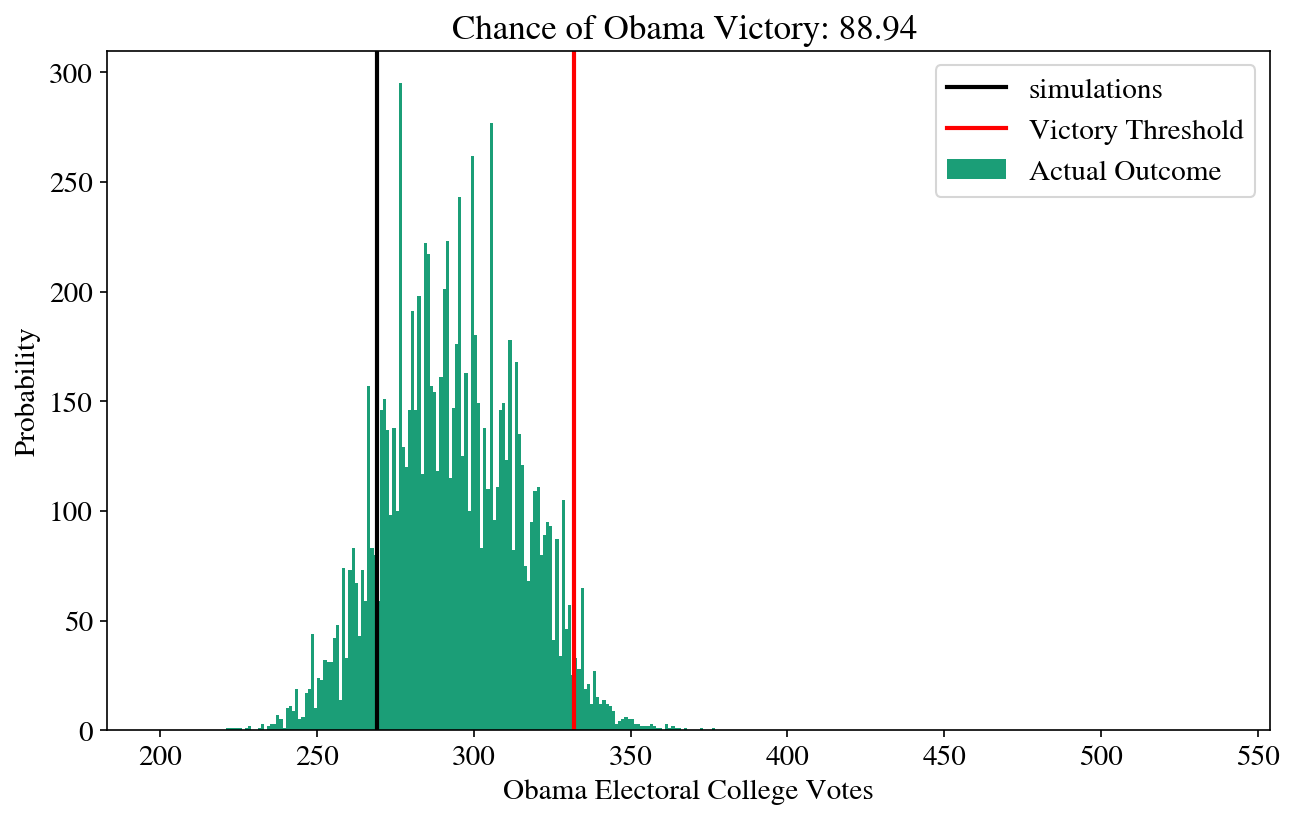

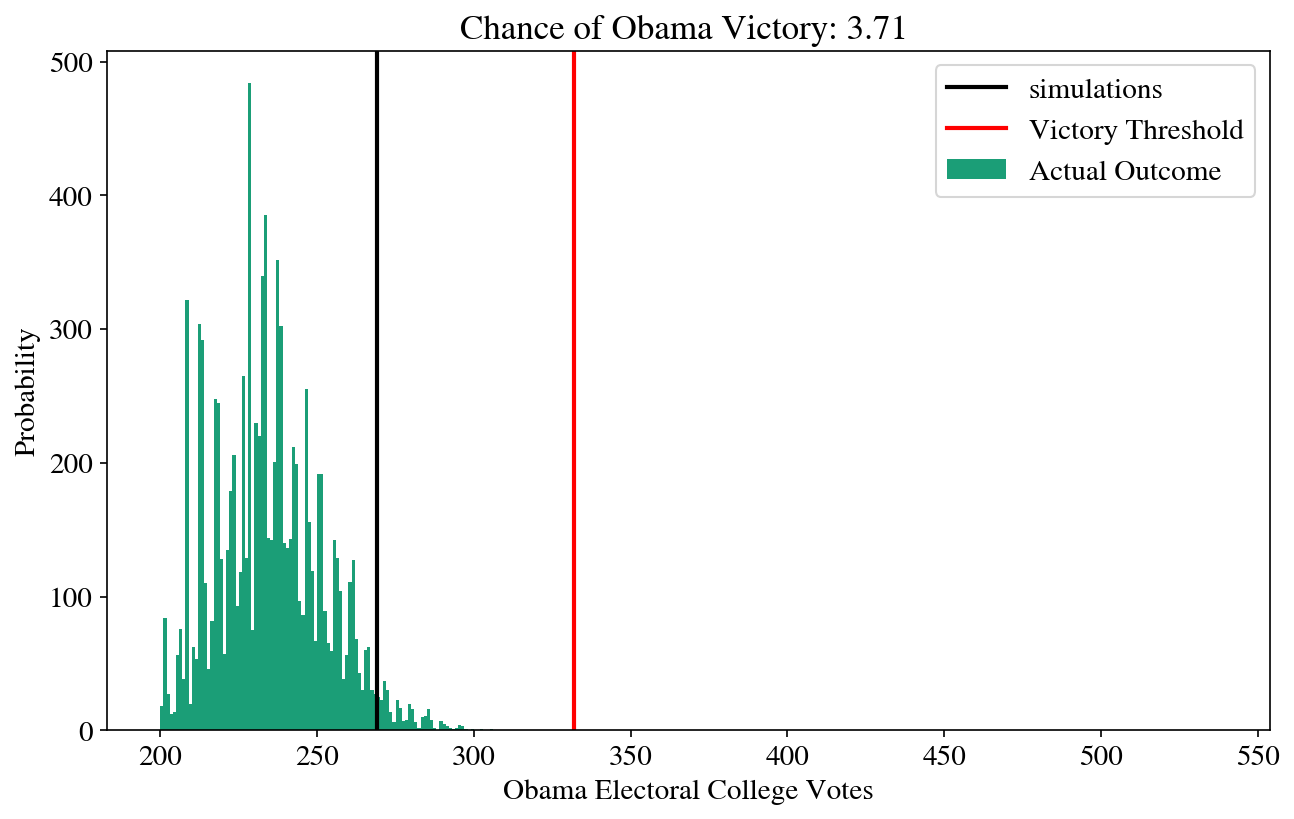

In [21]:
modelOne = biased_gallup_poll(gallupData, 1.0)
modelOne = modelOne.join(electoral_votes)
modelFive = biased_gallup_poll(gallupData, 5.0)
modelFive = modelFive.join(electoral_votes)

simOne = simulate_election(modelOne, 10000)
simFive = simulate_election(modelFive, 10000)

plot_simulation(simOne)
plt.show()
plot_simulation(simFive)
plt.show()

In [22]:
gallup_08 = pd.read_csv("data/g08.csv").set_index('State')
results_08 = pd.read_csv('data/2008results.csv').set_index('State')

prediction_08 = gallup_08[['Dem_Adv']]
prediction_08['Dem_Win']=results_08["Obama Pct"] - results_08["McCain Pct"]
prediction_08.head()

C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Dem_Adv,Dem_Win
State,,
Alabama,-0.8,-21.58
Alaska,-10.6,-21.53
Arizona,-0.4,-8.52
Arkansas,12.5,-19.86
California,19.4,24.06


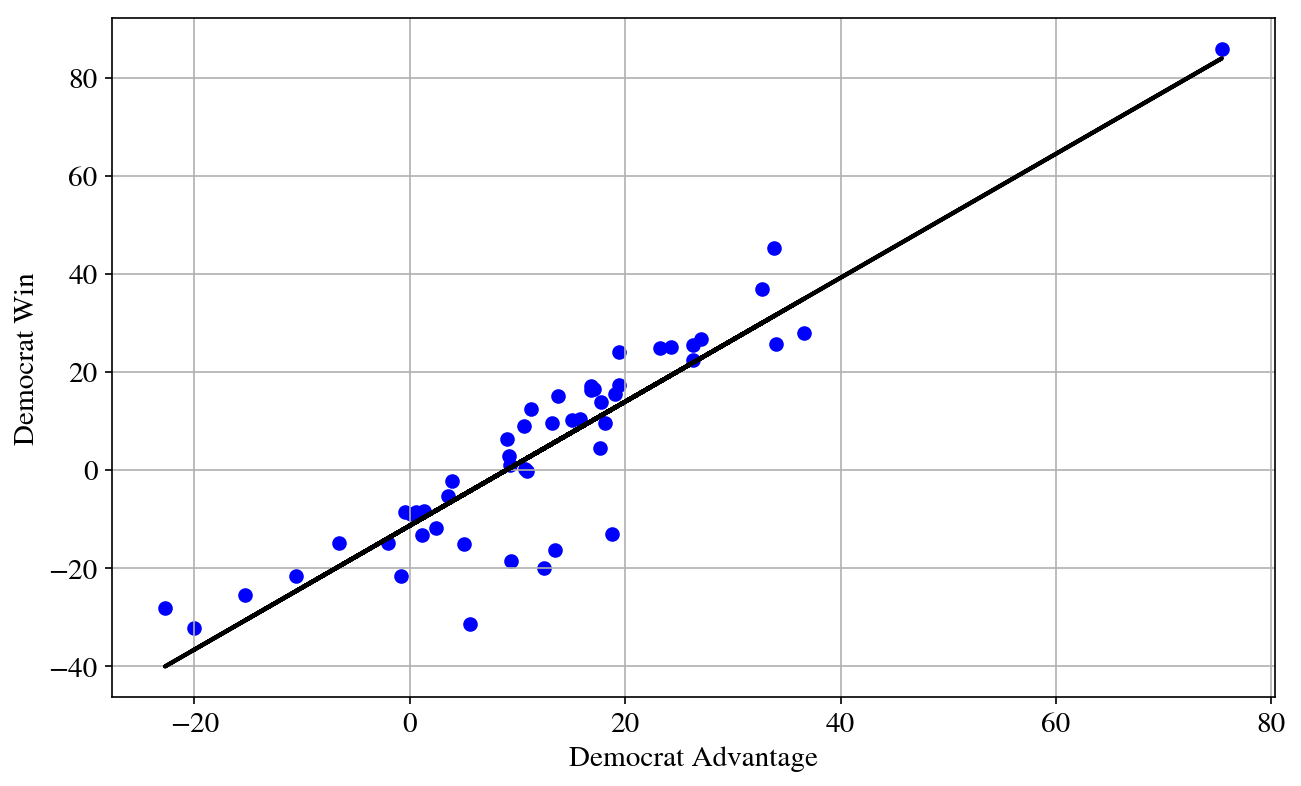

In [23]:
from sklearn.linear_model import LinearRegression

X = np.array(prediction_08.Dem_Adv).reshape((-1, 1))
y = np.array(prediction_08.Dem_Win).reshape((-1, 1))

linReg = LinearRegression()
linReg.fit(X, y)

model = linReg.predict(X)

plt.scatter(X, y, color = 'b')
plt.plot(X, model, 'k')
plt.xlabel("Democrat Advantage")
plt.ylabel("Democrat Win")
plt.grid()

In [25]:
prediction_08[(prediction_08.Dem_Win < 0) & (prediction_08.Dem_Adv > 0)]

,Dem_Adv,Dem_Win
State,,
Arkansas,12.5,-19.86
Georgia,3.6,-5.21
Kentucky,13.5,-16.23
Louisiana,9.4,-18.63
Mississippi,1.1,-13.18
Missouri,10.9,-0.14
Montana,3.9,-2.26
North Dakota,0.6,-8.63
Oklahoma,5.6,-31.30


In [27]:
bias = (prediction_08.Dem_Adv - prediction_08.Dem_Win).mean()
bias

8.068039215686275

[213 211 213 ..., 213 208 206]


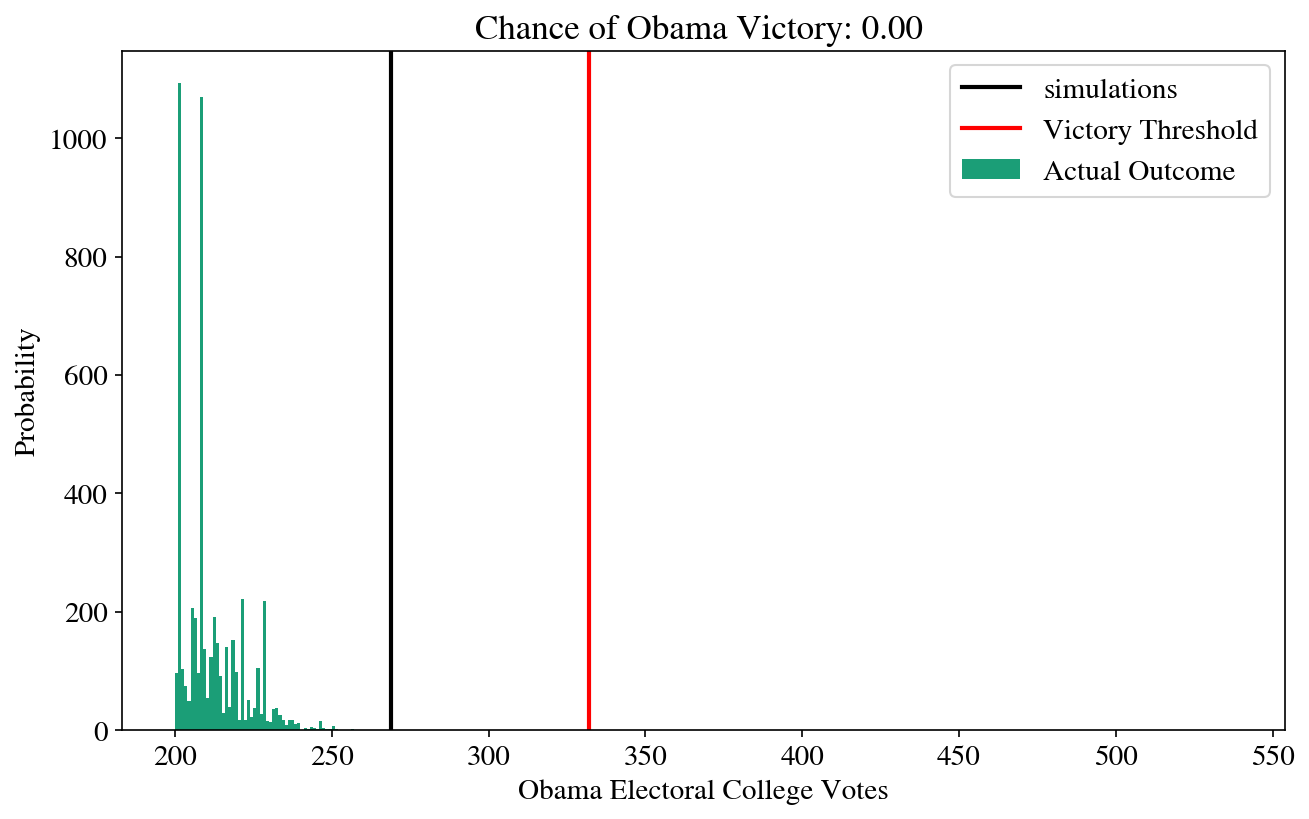

In [28]:
calibratedModel = biased_gallup_poll(gallupData, bias)
calibratedModel = calibratedModel.join(electoral_votes)
prediction = simulate_election(calibratedModel, 10000)
print prediction
plot_simulation(prediction)

**Logistic Considerations:**

In [29]:
national_results=pd.read_csv("data/nat.csv")
national_results.set_index('Year',inplace=True)
national_results.head()

,Dem,Rep
Year,,
2004,48,51
2008,53,46
2012,51,47


In [30]:
polls04=pd.read_csv("data/p04.csv")
polls04.State=polls04.State.replace(states_abbrev)
polls04.set_index("State", inplace=True);
polls04.head()

,Dem,Rep
State,,
Alabama,37,63
Alaska,34,62
Arizona,44,55
Arkansas,45,54
California,54,45


In [31]:
pvi08 = polls04.Dem - polls04.Rep - (national_results.xs(2004)['Dem'] - national_results.xs(2004)['Rep'])
pvi08.head()

State
Alabama      -23
Alaska       -25
Arizona       -8
Arkansas      -6
California    12
dtype: int64

In [32]:
demAdv = prediction_08.Dem_Adv - prediction_08.Dem_Adv.mean()
e2008 = pd.DataFrame(dict(pvi = pvi08, Dem_Adv = demAdv))
e2008['obama_win'] = 1*(prediction_08.Dem_Win > 0)
demWin = results_08['Obama Pct'] - results_08['McCain Pct']
e2008['Dem_Win'] = demWin
e2008 = e2008.sort_index()
e2008.head()

,Dem_Adv,pvi,obama_win,Dem_Win
State,,,,
Alabama,-13.154902,-23,0,-21.58
Alaska,-22.954902,-25,0,-21.53
Arizona,-12.754902,-8,0,-8.52
Arkansas,0.145098,-6,0,-19.86
California,7.045098,12,1,24.06


In [33]:
pvi12 = e2008.Dem_Win - (national_results.xs(2008)['Dem'] - national_results.xs(2008)['Rep'])
e2012 = pd.DataFrame(dict(pvi=pvi12, Dem_Adv=gallupData.Dem_Adv - gallupData.Dem_Adv.mean()))
e2012 = e2012.sort_index()
e2012.head()

,Dem_Adv,pvi
State,,
Alabama,-14.684314,-28.58
Alaska,-9.484314,-28.53
Arizona,-8.584314,-15.52
Arkansas,-0.384314,-26.86
California,12.615686,17.06


In [34]:
results2012 = pd.read_csv("data/2012results.csv")
results2012.set_index("State", inplace=True)
results2012 = results2012.sort_index()
results2012.head()

,Winner
State,
Alabama,0
Alaska,0
Arizona,0
Arkansas,0
California,1


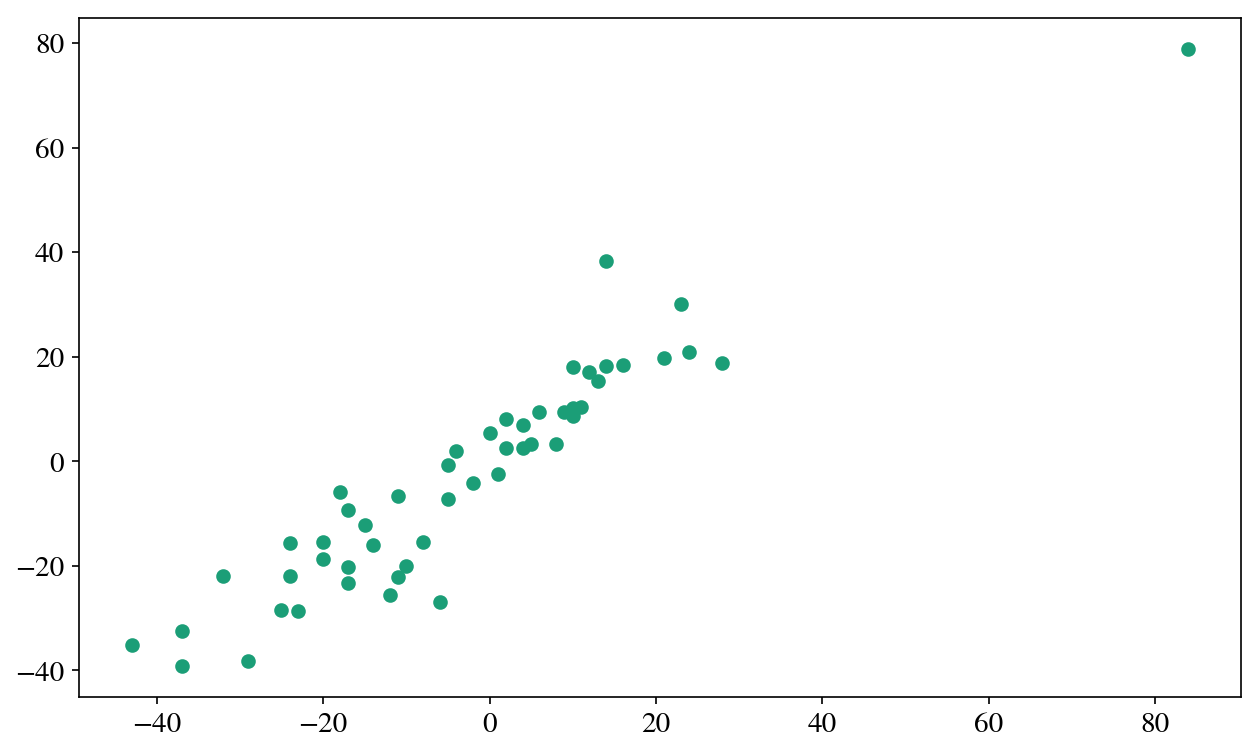

In [35]:
plt.scatter(e2008.pvi, e2012.pvi)

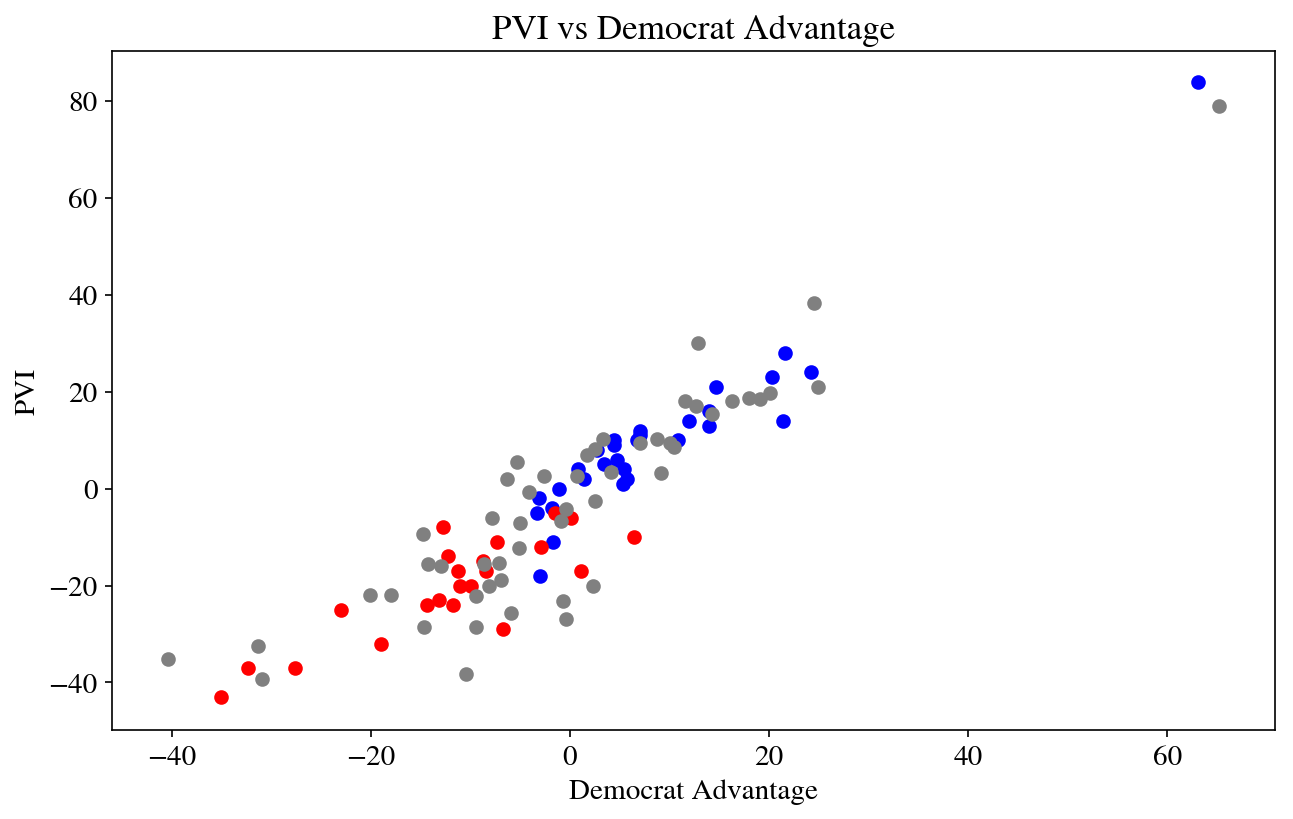

In [36]:
plt.scatter(e2008[e2008.obama_win == 1].Dem_Adv, e2008[e2008.obama_win == 1].pvi, color = 'b')
plt.scatter(e2008[e2008.obama_win == 0].Dem_Adv, e2008[e2008.obama_win == 0].pvi, color = 'r')
plt.scatter(e2012.Dem_Adv, e2012.pvi, color = 'gray')
plt.xlabel("Democrat Advantage")
plt.ylabel("PVI")
plt.title("PVI vs Democrat Advantage")

In [37]:
from sklearn.linear_model import LogisticRegression

def prepare_features(frame2008, featureslist):
    y= frame2008.obama_win.values
    X = frame2008[featureslist].values
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    return y, X

In [38]:
def fit_logistic(frame2008, frame2012, featureslist, reg=0.0001):
    y, X = prepare_features(frame2008, featureslist)
    clf2 = LogisticRegression(C=reg)
    clf2.fit(X, y)
    X_new = frame2012[featureslist]
    obama_probs = clf2.predict_proba(X_new)[:, 1]
    
    df = pd.DataFrame(index=frame2012.index)
    df['Obama'] = obama_probs
    return df, clf2

In [39]:
from sklearn.grid_search import GridSearchCV

def cv_optimize(frame2008, featureslist, n_folds=10, num_p=100):
    y, X = prepare_features(frame2008, featureslist)
    clf = LogisticRegression()
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_

C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [40]:
def cv_and_fit(frame2008, frame2012, featureslist, n_folds=5):
    bp, bs = cv_optimize(frame2008, featureslist, n_folds=n_folds)
    predict, clf = fit_logistic(frame2008, frame2012, featureslist, reg=bp['C'])
    return predict, clf

In [41]:
predict, clf = cv_and_fit(e2008, e2012, ['Dem_Adv', 'pvi'])
predict = predict.join(electoral_votes)
predict.head()

,Obama,Votes
State,,
Alabama,0.004367,9
Alaska,0.008462,3
Arizona,0.068250,11
Arkansas,0.033851,6
California,0.994326,55


C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


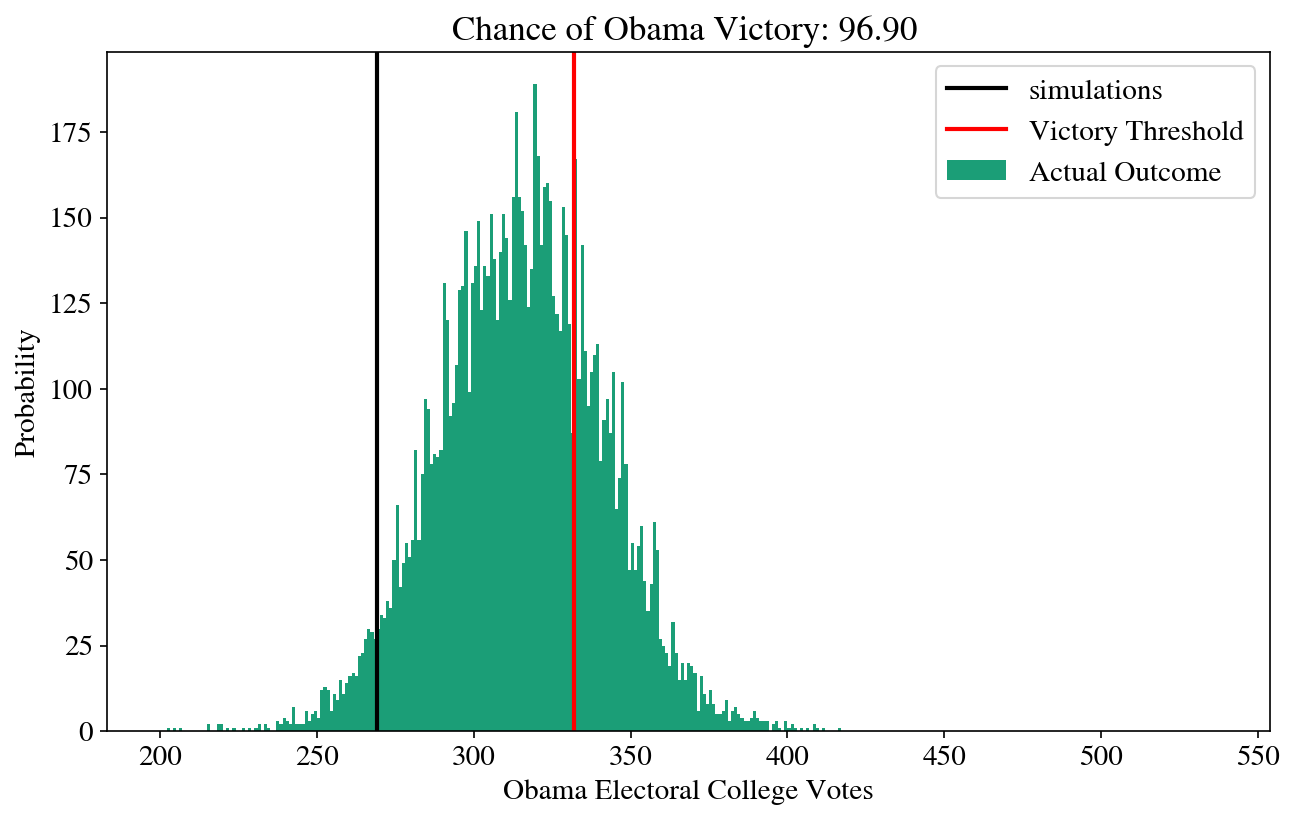

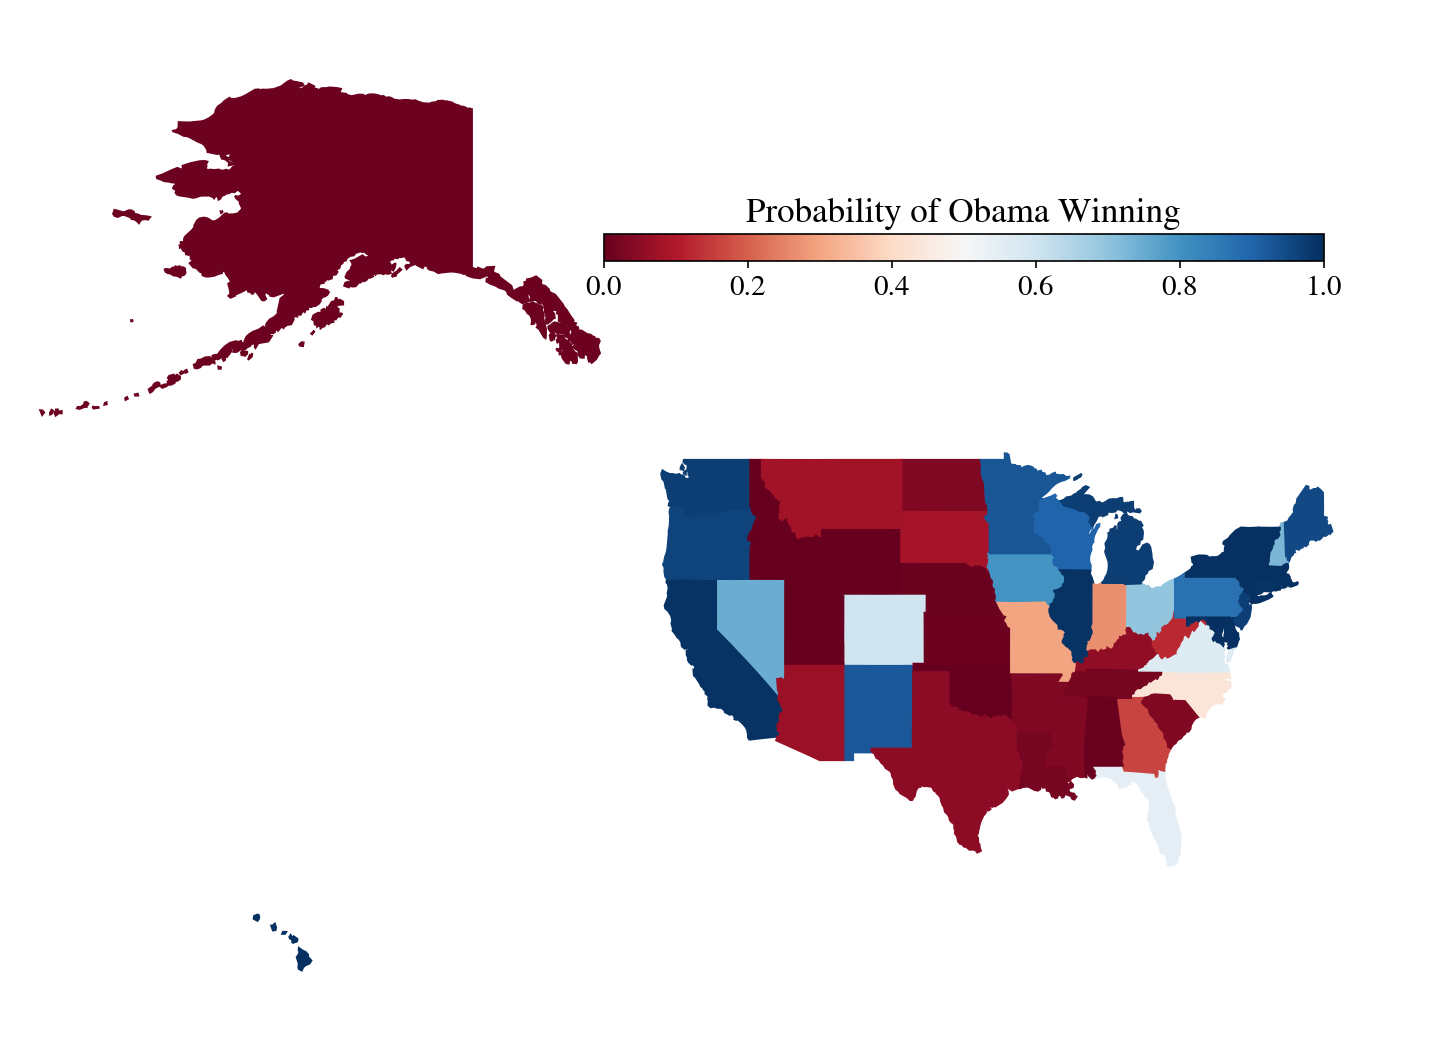

In [42]:
#predict = predict.join(electoral_votes)
prediction_mod = simulate_election(predict, 10000)
plot_simulation(prediction_mod)
make_map(predict.Obama, "Probability of Obama Winning")

In [43]:
from matplotlib.colors import ListedColormap
def points_plot(e2008, e2012, clf):
    """
    e2008: The e2008 data
    e2012: The e2012 data
    clf: classifier
    """
    Xtrain = e2008[['Dem_Adv', 'pvi']].values
    Xtest = e2012[['Dem_Adv', 'pvi']].values
    ytrain = e2008['obama_win'].values == 1
    
    X=np.concatenate((Xtrain, Xtest))
    
    # evenly sampled points
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    #plot background colors
    ax = plt.gca()
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='RdBu', alpha=.5)
    cs2 = ax.contour(xx, yy, Z, cmap='RdBu', alpha=.5)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    
    # Plot the 2008 points
    ax.plot(Xtrain[ytrain == 0, 0], Xtrain[ytrain == 0, 1], 'ro', label='2008 McCain')
    ax.plot(Xtrain[ytrain == 1, 0], Xtrain[ytrain == 1, 1], 'bo', label='2008 Obama')
        
    # and the 2012 points
    ax.scatter(Xtest[:, 0], Xtest[:, 1], c='k', marker="s", s=50, facecolors="k", alpha=.5, label='2012')
    plt.legend(loc='upper left', scatterpoints=1, numpoints=1)

    return ax

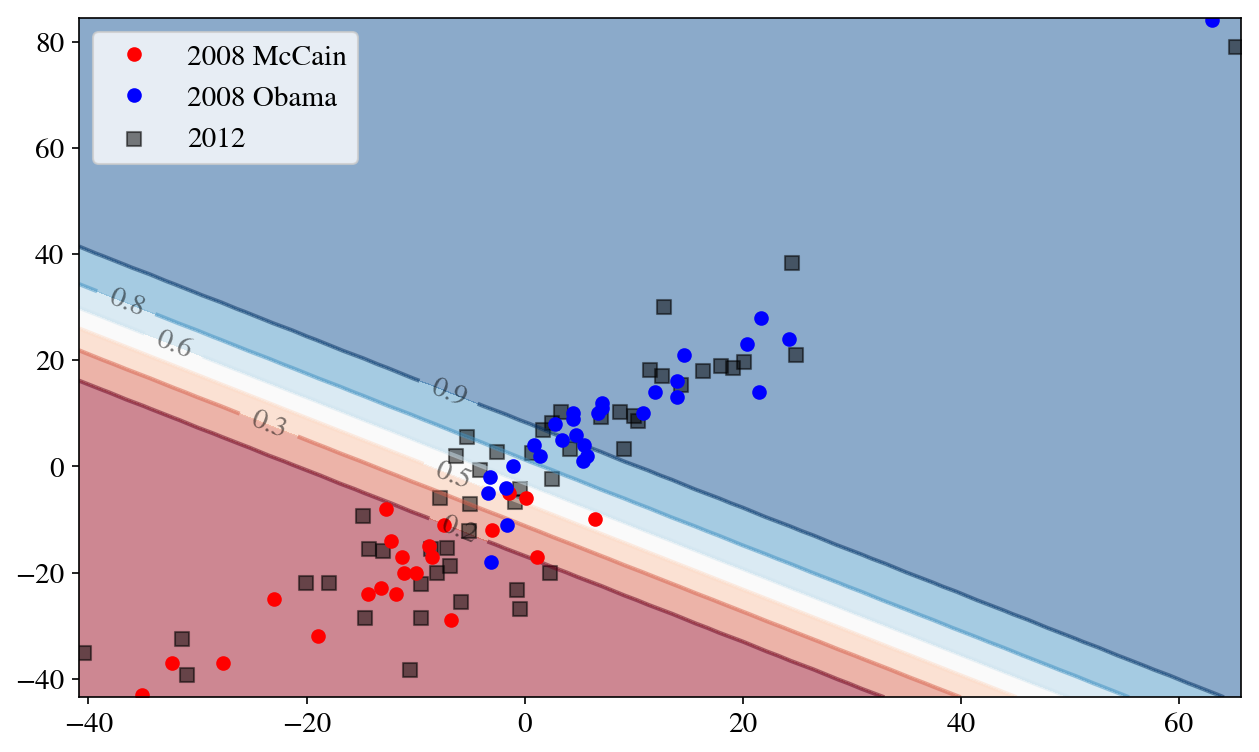

In [44]:
points_plot(e2008, e2012, clf)

**Poll Aggregation:**

In [45]:
multipoll = pd.read_csv('data/cleaned-state_data2012.csv', index_col=0)

#convert state abbreviation to full name
multipoll.State.replace(states_abbrev, inplace=True)

#convert dates from strings to date objects, and compute midpoint
multipoll.start_date = pd.to_datetime(multipoll.start_date)
multipoll.end_date = pd.to_datetime(multipoll.end_date)
multipoll['poll_date'] = multipoll.start_date + (multipoll.end_date - multipoll.start_date).values / 2

#compute the poll age relative to Oct 2, in days
multipoll['age_days'] = (today - multipoll['poll_date']).values / np.timedelta64(1, 'D')

#drop any rows with data from after oct 2
multipoll = multipoll[multipoll.age_days > 0]

#drop unneeded columns
multipoll = multipoll.drop(['Date', 'start_date', 'end_date', 'Spread'], axis=1)

#add electoral vote counts
multipoll = multipoll.join(electoral_votes, on='State')

#drop rows with missing data
multipoll.dropna()

multipoll.head()

,Pollster,State,MoE,Obama (D),Romney (R),Sample,obama_spread,poll_date,age_days,Votes
0,Rasmussen Reports,Washington,4.5,52.0,41.0,500.0,11.0,2012-09-26 00:00:00,6.0,12
1,Gravis Marketing,Washington,4.6,56.0,39.0,625.0,17.0,2012-09-21 12:00:00,10.5,12
2,Elway Poll,Washington,5.0,53.0,36.0,405.0,17.0,2012-09-10 12:00:00,21.5,12
3,SurveyUSA,Washington,4.4,54.0,38.0,524.0,16.0,2012-09-08 00:00:00,24.0,12
4,SurveyUSA,Washington,4.4,54.0,37.0,524.0,17.0,2012-08-01 12:00:00,61.5,12


In [46]:
def state_average(data):
    dataFrame = pd.DataFrame(dict(poll_mean = data.groupby(['State']).obama_spread.mean()))
    dataFrame['poll_std'] = data.groupby(['State']).obama_spread.std()
    return dataFrame

avg = state_average(multipoll).join(electoral_votes, how='outer')
avg.head()

,poll_mean,poll_std,Votes
State,,,
Alabama,NaN,NaN,9
Alaska,NaN,NaN,3
Arizona,-5.500000,4.559548,11
Arkansas,-20.333333,4.041452,6
California,18.950000,5.548589,55


In [47]:
def default_missing(results):
    red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Wyoming"]
    blue_states = ["Delaware", "District of Columbia", "Hawaii"]
    results.ix[red_states, ["poll_mean"]] = -100.0
    results.ix[red_states, ["poll_std"]] = 0.1
    results.ix[blue_states, ["poll_mean"]] = 100.0
    results.ix[blue_states, ["poll_std"]] = 0.1
default_missing(avg)
avg.head()

C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


,poll_mean,poll_std,Votes
State,,,
Alabama,-100.00,0.100000,9
Alaska,-100.00,0.100000,3
Arizona,-5.50,4.559548,11
Arkansas,-100.00,0.100000,6
California,18.95,5.548589,55


In [48]:
def aggregated_poll_model(data):
    mean = data.poll_mean
    std = data.poll_std
    cdf = 0.5 * (1 + erf(mean / np.sqrt(2 * std * std)))
    return pd.DataFrame(dict(Obama = cdf, Votes = data.Votes))

aggModel = aggregated_poll_model(avg)
aggModel.head()

,Obama,Votes
State,,
Alabama,0.000000,9
Alaska,0.000000,3
Arizona,0.113859,11
Arkansas,0.000000,6
California,0.999681,55


C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


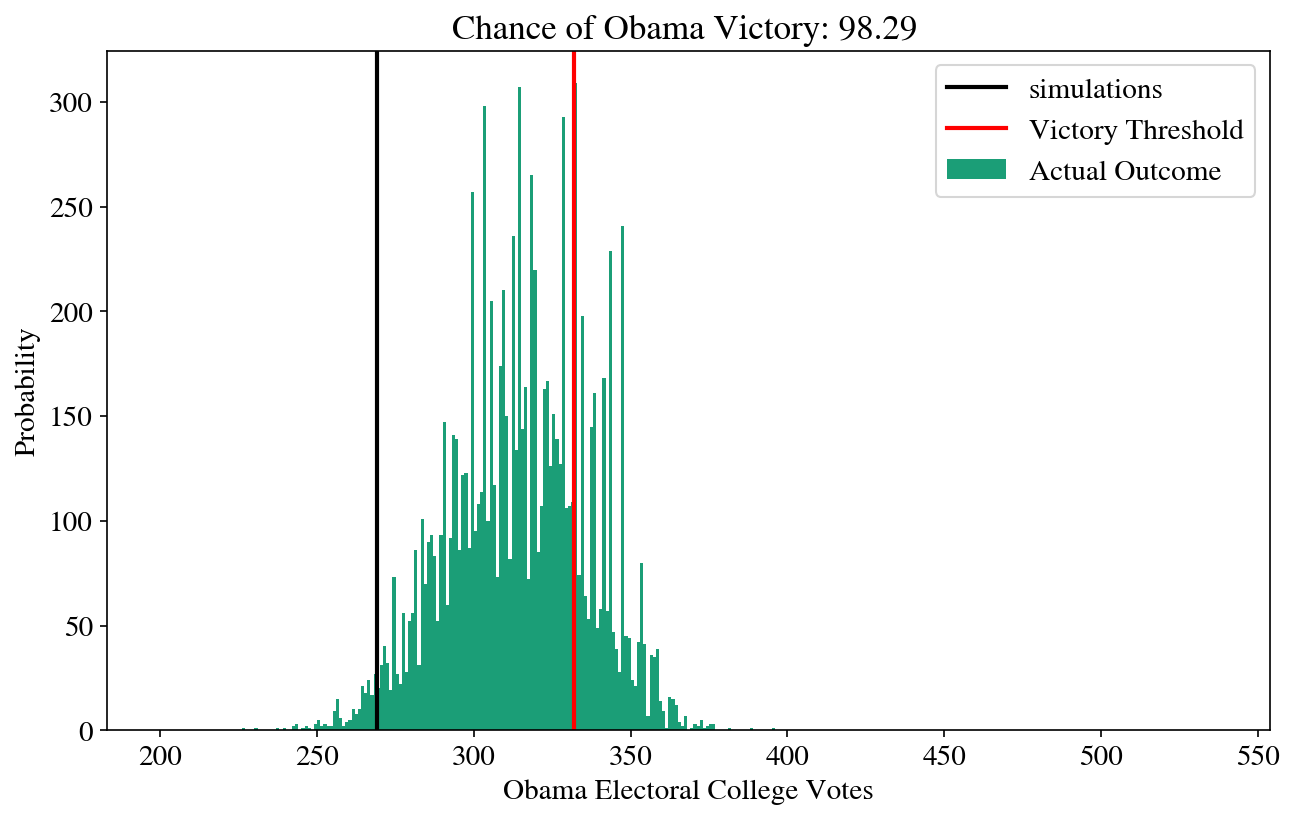

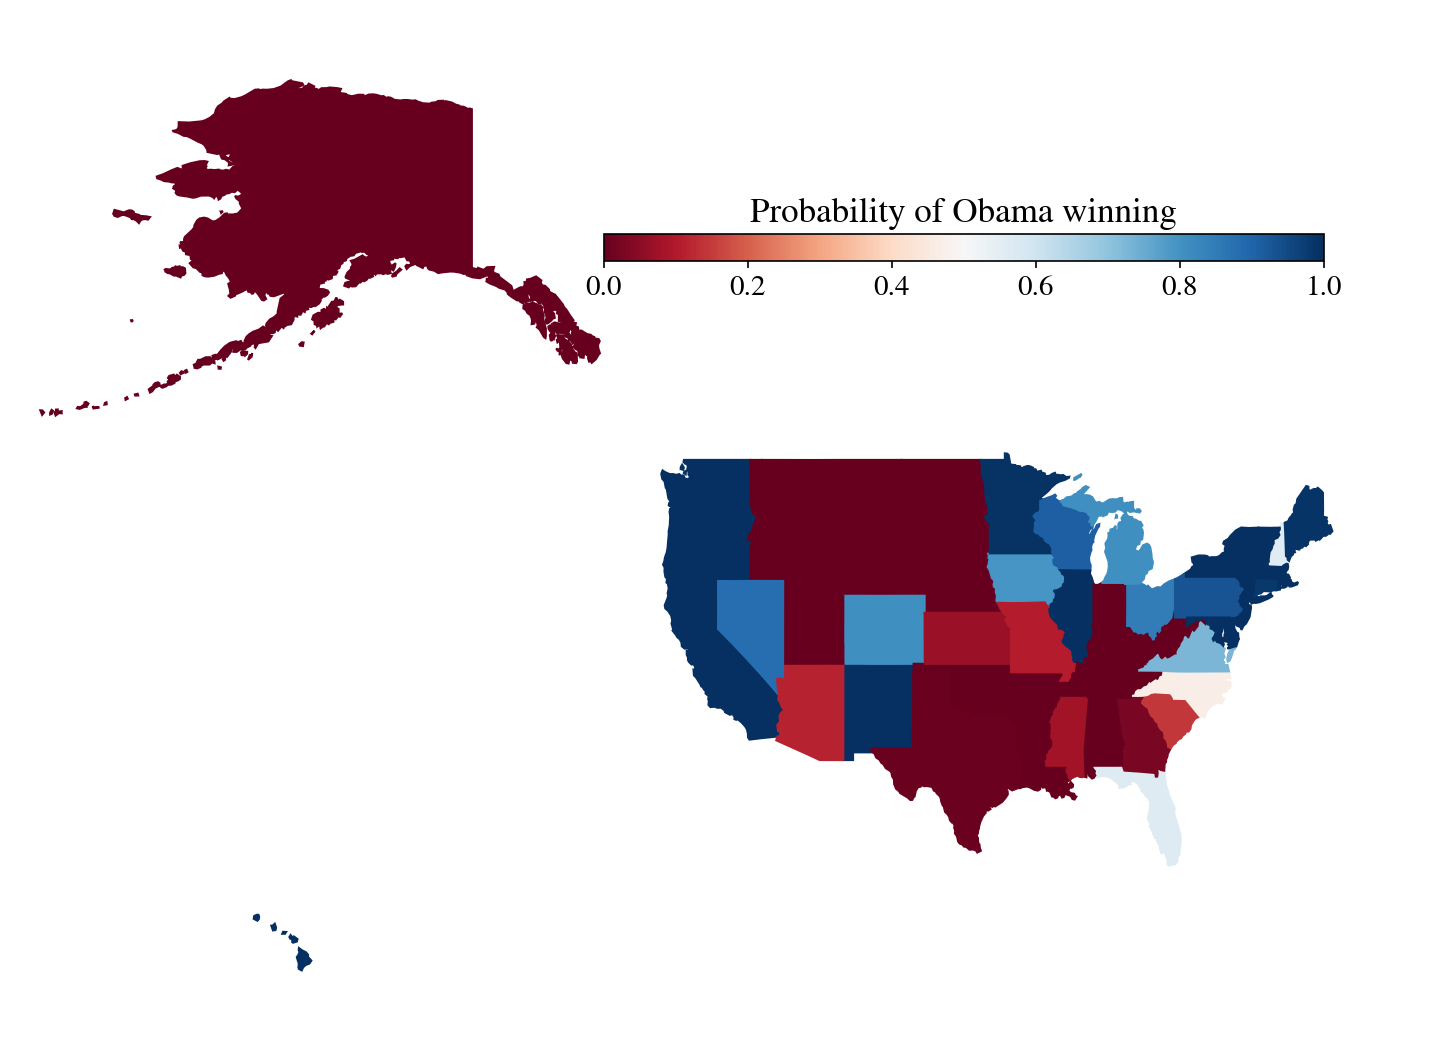

In [49]:
simAggModel = simulate_election(aggModel, 10000)
plot_simulation(simAggModel)
make_map(aggModel.Obama, "Probability of Obama winning")

In [50]:
multipoll[multipoll.State=="Kansas"]

,Pollster,State,MoE,Obama (D),Romney (R),Sample,obama_spread,poll_date,age_days,Votes
427,SurveyUSA,Kansas,4.4,39.0,48.0,510.0,-9.0,2011-11-19 12:00:00,317.5,6
428,SurveyUSA,Kansas,3.5,31.0,56.0,800.0,-25.0,2011-11-10 00:00:00,327.0,6


In [51]:
def weighted_state_average(data):
    dataFrame = state_average(data).join(electoral_votes, how='outer')
    #dataFrame['poll_std'] = dataFrame['poll_mean'][(dataFrame['poll_std'] is None)] * 0.5
    default_missing(dataFrame)
    dataFrame['N'] = data.groupby(['State']).Pollster.count()
    return dataFrame

predModel = weighted_state_average(multipoll)
predModel.head()

C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


,poll_mean,poll_std,Votes,N
State,,,,
Alabama,-100.00,0.100000,9,NaN
Alaska,-100.00,0.100000,3,NaN
Arizona,-5.50,4.559548,11,20.0
Arkansas,-100.00,0.100000,6,3.0
California,18.95,5.548589,55,20.0


**Final Simulation:**

C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.
C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\Harvey_Specter\Anaconda2\lib\site-packages\ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


314.48200000000003

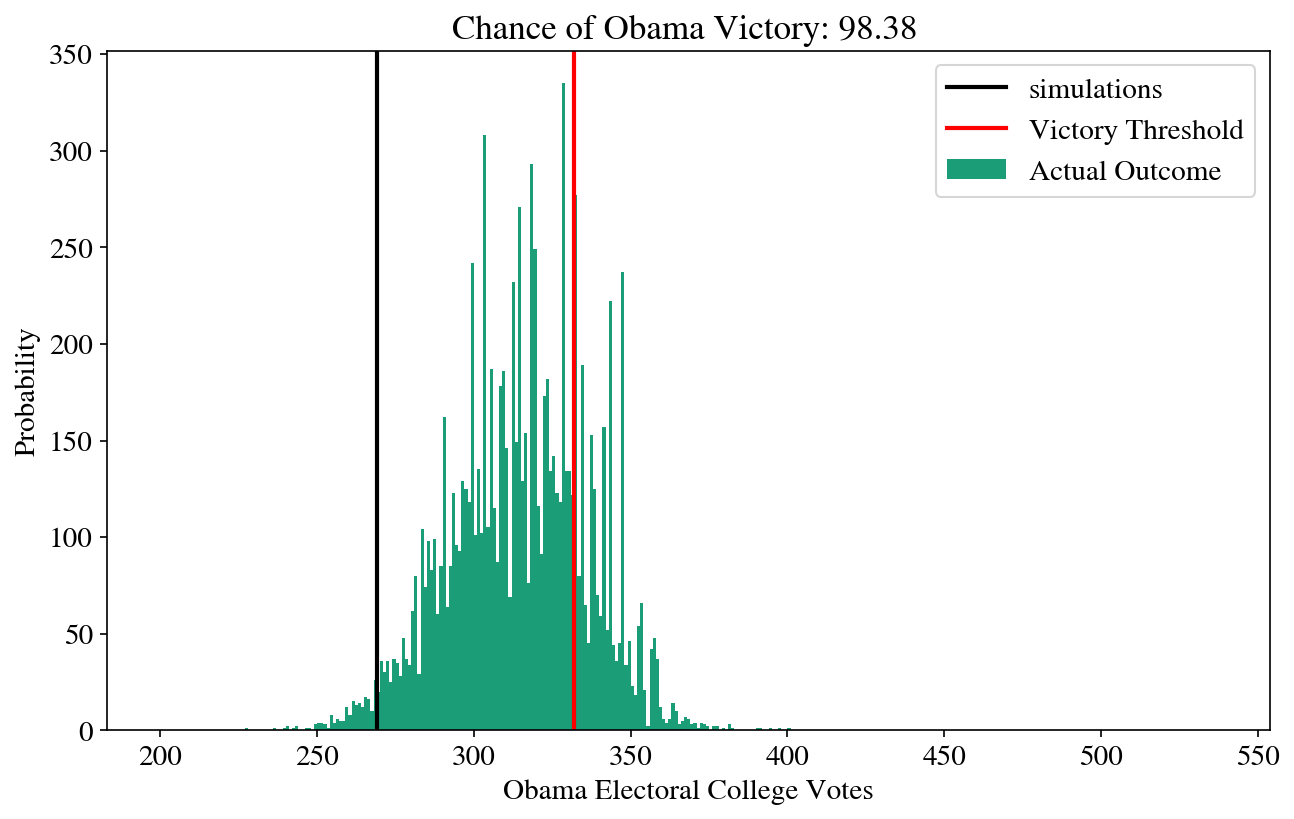

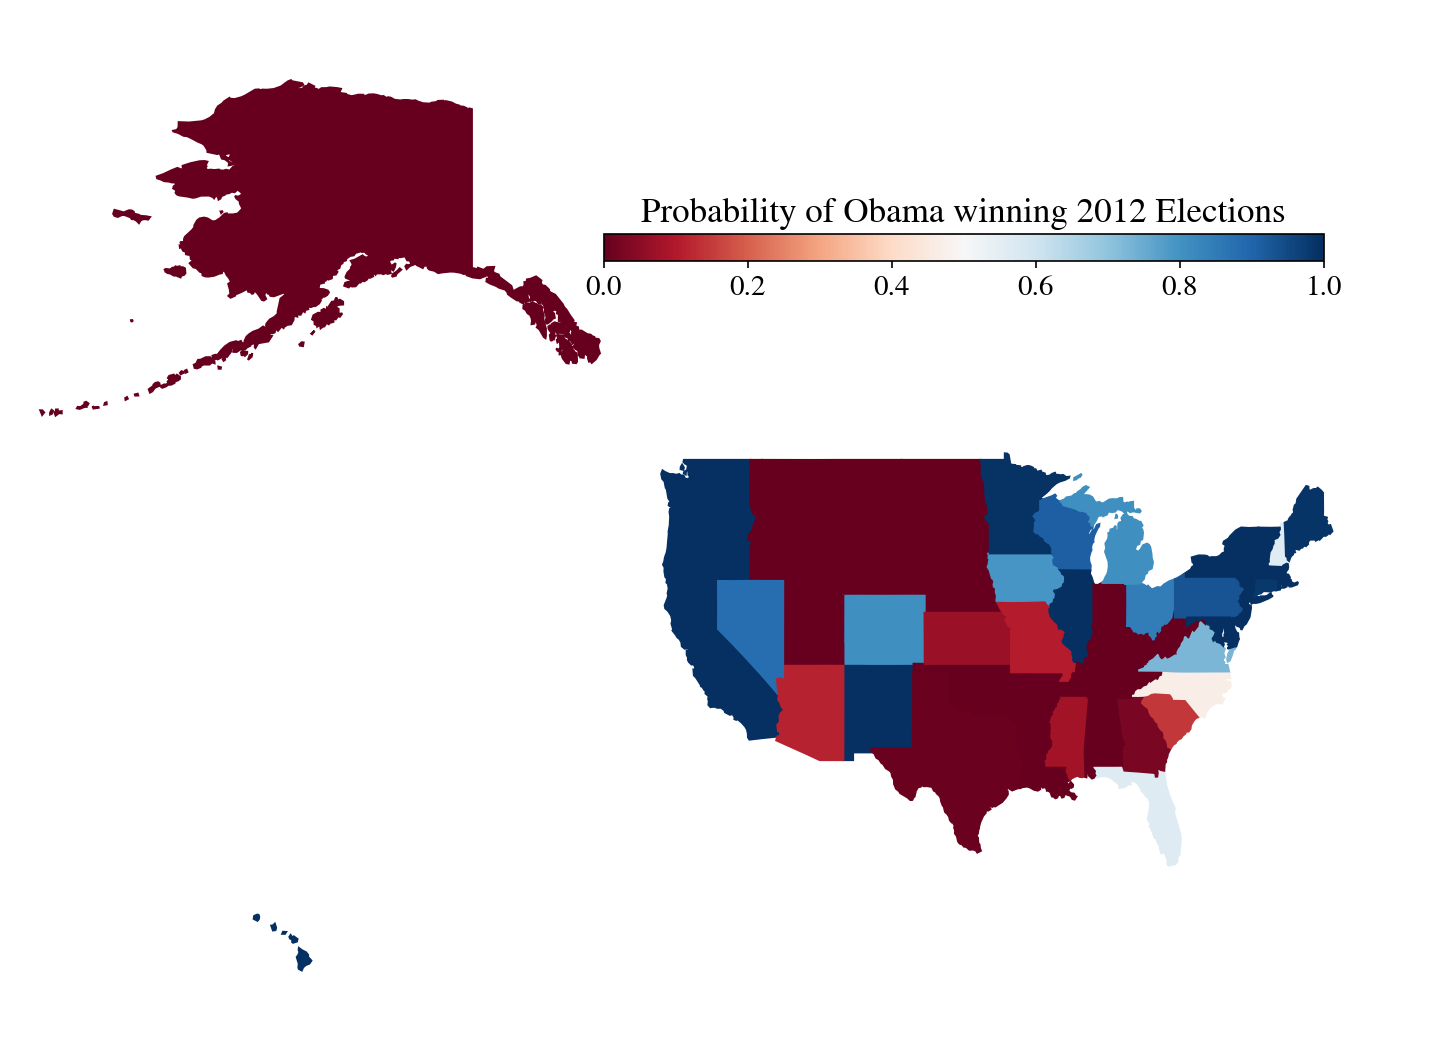

In [52]:
finalModel = weighted_state_average(multipoll)
default_missing(finalModel)
finalModel = aggregated_poll_model(finalModel)

finalPrediction = simulate_election(finalModel, 10000)
plot_simulation(finalPrediction)
make_map(finalModel.Obama, "Probability of Obama winning 2012 Elections")
finalPrediction.mean()